In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import evosax

from typing import NamedTuple
from functools import partial
import math

In [3]:
import xylo
import xylo.types as t
import xylo.woods
import xylo.cut

import xylo.receptance as r
import xylo.sweep as xs

import xylo.loss.receptance as xlr

In [137]:
CN4 = 40
CS4 = 41
DN4 = 42
DS4 = 43
EN4 = 44
FN4 = 45
FS4 = 46
GN4 = 47
GS4 = 48
AN4 = 49
CN8 = 88

def note_to_freq(note, base=444):
  offset = note - AN4
  return math.pow(2, offset / 12) * base

print(note_to_freq(CN4, base=440), " expect 261")
print(note_to_freq(AN4, base=440), " expect 440")
print(note_to_freq(56, base=440), " expect 659")
print(note_to_freq(AN4+12, base=440), " expect 880")

# based on yamaha
note_to_len_dict = {
    45: 380,
    46: 375,
    47: 370,
    48: 365,
    49: 360,
    50: 355,
    51: 350,
    52: 340,
    53: 335,
    54: 330,
    55: 325,
    56: 320,
    57: 310,
    58: 305,
    59: 300,
    60: 295,
    61: 290,
    62: 285,
    63: 280,
    64: 270,
    65: 265,
    66: 260,
    68: 250,
    69: 240,
    70: 235,
    71: 230,
    72: 225,
    73: 220,
    74: 215,
    75: 210,
    76: 200,
    77: 195,
    78: 190,
    79: 185,
    80: 180,
    81: 170,
    82: 165,
    83: 160,
    84: 155,
    85: 150,
    86: 145,
    87: 140,
    88: 130
}
def note_to_len(note):
    return note_to_len_dict[note] / 1000


261.6255653005986  expect 261
440.0  expect 440
659.2551138257398  expect 659
880.0  expect 880


In [237]:
note = 59

bar_default = t.BarProps(width = 0.040, depth = 0.020, length = note_to_len(note), elements = 300, min_depth = 0.010)
fundamental = note_to_freq(note) # / 1.5

wood = xylo.woods.spotted_gum
# weights = jnp.array([[1, -1.0]])
# weights = jnp.array([[3, -0.75]])
# weights = jnp.array([[1, -1.0], [3, -1.0]])
# weights = jnp.array([[1, -1.0], [1.1, 1.0], [3, -1.0], [3.3, 1.0]])
# weights = jnp.array([[1, -1.0], [3, -0.75], [6, -0.5]])
# weights = jnp.array([[0.5, 0.1], [1, -1.0], [2, 0.1], [3, -0.75], [4, 0.1], [6, -0.5]])
# weights = jnp.array([[1, -1.0]])
# weights = jnp.array([[0.9, 0.1], [1, -1.0], [1.1, 0.1], [2.9, 0.075], [3, -0.75], [3.1, 0.075], [5.9, 0.05], [6, -0.5], [6.1, 0.05]])

# weights = jnp.array([[1, -1.0], [0.9, 1.0]]) # , [3, -0.9], [2.9, 0.9], [6, -0.8], [5.9, 0.8]])

# weights = jnp.array([[1, -1.0], [0.9, 1.0], [3, -0.9], [2.9, 0.9], [6, -0.8], [5.9, 0.8]])
# weights = jnp.array([[0.5, 1.0], [0.75, 1.0], [1, -1.0], [0.9, 1.0], [1.1, -1.0], [3, -0.9], [2.9, 0.9], [3.1, -0.9], [6, -0.8], [5.9, 0.8], [6.1, -0.8]])

# weights = jnp.array([[0.1, 1.0], [0.2, 1.0], [0.3, 1.0], [0.4, 1.0], [0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0], [0.9, 1.0], [1, -1.0]]) # [3, -0.9], [2.9, 0.9]])
# weights = jnp.array([[0.1, 1.0], [0.2, 1.0], [0.3, 1.0], [0.4, 1.0], [0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0], [0.9, 1.0], [1, -1.0], [3, -0.9], [2.9, 0.9]])
# weights = jnp.array([[0.1, 1.0], [0.2, 1.0], [0.3, 1.0], [0.4, 1.0], [0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0], [0.9, 1.0], [1, -1.0], [3, -0.5], [2.9, 0.5], [6, -0.2], [5.9, 0.2]])

weights = jnp.array([[0.9, 1.0], [1, -1.0], [3, -0.75], [2.9, 0.75], [6, -0.5], [5.9, 0.5]])


# p = 0.1
# r1 = -1
# r2 = -0.5
# r3 = -0.25
# w = [[x/10, r1 if x == 10 else r2 if x == 30 else r3 if x == 6 else p] for x in range(1, 70)]
# weights = jnp.array(w)
print(fundamental, bar_default.length)

791.1180617086213 0.3


In [238]:
def mkBarLength(l: float):
    # if l in range [0,1] then range from 0.5*len to 1.5*len
    return bar_default.length # / 2 + bar_default.length * l

def mkCut3(x):
  bar_ = bar_default._replace(length = mkBarLength(x[-1]))
  cut_ = t.CutCubic(x[0], x[1], x[2] * bar_default.depth)
  sections_ = xylo.cut.cubic(bar_, cut_)
  return bar_, sections_

def mkCut4(x):
  bar_ = bar_default._replace(length = mkBarLength(x[-1]))
  sections_ = xylo.cut.quartic(bar_, x[0:-1])
  return bar_, sections_

def mkCutSpline(x):
  cut, length = x[0:-1], x[-1]
  bar_ = bar_default._replace(length = mkBarLength(length))
  sections_ = xylo.cut.spline(bar_, cut) # , symmetric=False)
  return bar_, sections_

def loss_receptance(sections: t.Sections, wood: t.Wood, bar: t.BarProps, fundamental: float, ws: jnp.ndarray):
    # sections = xylo.cut.cubic(bar, cut)
    wsT = ws.T
    rs  = jax.vmap(lambda w: r.receptance_scalar(wood, bar, sections, w))(wsT[0] * 2 * jnp.pi * fundamental)
    # jax.debug.print("{rs}", rs=rs)
    return -jnp.dot(jnp.minimum(rs, 0.0), wsT[1])

def loss_harmonic(sections: t.Sections, wood: t.Wood, bar: t.BarProps, sweep_opts: t.FrequencySweep, target: jnp.ndarray, weights: jnp.ndarray = jnp.array([1.0, 0.0, 0.0])):
    sweep = xylo.sweep.sweep(wood, bar, sections, sweep_opts)
    diff = jnp.abs((target - sweep.harmonics) / target)
    # jax.debug.print("S={s}", s=sweep.harmonics)
    loss = diff * weights
    return jnp.sum(loss)



@jax.jit
def loss3(x):
  bar, sections = mkCut3(x)
  return loss_receptance(sections, wood, bar, fundamental, weights) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss4(x):
  bar, sections = mkCut4(x)
  return loss_receptance(sections, wood, bar, fundamental, weights) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss_spline(x):
  bar, sections = mkCutSpline(x)
  return loss_receptance(sections, wood, bar, fundamental, weights) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

fundamental_goals = jnp.array([fundamental * 1, fundamental * 3, fundamental * 6])
loss_harm_sweep_opt = t.FrequencySweep(start_freq = fundamental * 0.1, stop_freq = fundamental * 10, num_freq = 30, bisect_iters = 2)

@jax.jit
def loss3_harmonic(x):
  bar, sections = mkCut3(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss4_harmonic(x):
  bar, sections = mkCut4(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss_spline_harmonic(x):
  bar, sections = mkCutSpline(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))



In [231]:
num_generations = 100

rng = jax.random.key(0)
# for Cut3/Cut4
# strategy = evosax.CMA_ES(popsize = 500, num_dims=5)
strategy = evosax.OpenES(popsize = 2000, num_dims=5)
# strategy = evosax.SNES(popsize = 500, num_dims=5)
es_params = strategy.default_params.replace(init_min = 0, init_max=1, clip_min = 0, clip_max=1)

# for splines
# strategy = evosax.SNES(popsize = 500, num_dims=6)
# strategy = evosax.OpenES(popsize = 500, num_dims=10)
# es_params = strategy.default_params.replace(init_min = 0, init_max=1, clip_min = 0, clip_max=1)

es_state = strategy.initialize(rng, es_params)

for i in range(num_generations):
  rng, rng_gen, rng_eval = jax.random.split(rng, 3)
  x, es_state = strategy.ask(rng_gen, es_state, es_params)
  fitness = jax.vmap(loss_spline_harmonic, in_axes = 0)(x)
  fitness = jnp.float32(fitness)
  es_state = strategy.tell(x, fitness, es_state, es_params)
  if i % 10 == 0:
    print(f"iteration {i}")
    print(es_state.best_member, es_state.best_fitness)
    bar_, sections = mkCutSpline(es_state.best_member)
    # print(sections.depths)
    swp = xs.sweep(wood, bar_, sections, t.sweep_default)
    print(swp.harmonics, swp.harmonics / fundamental, bar_.length)

es_state.mean, es_state.best_member, es_state.best_fitness

iteration 0
[0.32314612 0.56300937 0.41625089 0.32657005 0.2609046 ] 0.37815654
[ 610.50329693 2013.44517093 3904.57711753] [1.37500743 4.53478642 8.79409261] 0.36
iteration 10
[0.04403848 0.3251318  0.10400483 0.49498998 0.35129877] 0.0031537956
[ 444.97042431 1546.04388712 3557.50021985] [1.00218564 3.48208083 8.01238788] 0.36
iteration 20
[0.04403848 0.3251318  0.10400483 0.49498998 0.35129877] 0.0031537956
[ 444.97042431 1546.04388712 3557.50021985] [1.00218564 3.48208083 8.01238788] 0.36
iteration 30
[0.04403848 0.3251318  0.10400483 0.49498998 0.35129877] 0.0031537956
[ 444.97042431 1546.04388712 3557.50021985] [1.00218564 3.48208083 8.01238788] 0.36
iteration 40
[0.04403848 0.3251318  0.10400483 0.49498998 0.35129877] 0.0031537956
[ 444.97042431 1546.04388712 3557.50021985] [1.00218564 3.48208083 8.01238788] 0.36
iteration 50
[0.04403848 0.3251318  0.10400483 0.49498998 0.35129877] 0.0031537956
[ 444.97042431 1546.04388712 3557.50021985] [1.00218564 3.48208083 8.01238788] 0.36
i

(Array([-4.08802955,  2.60383715, -3.90199004,  2.63241182,  0.2126157 ],      dtype=float64),
 Array([0.04403848, 0.3251318 , 0.10400483, 0.49498998, 0.35129877],      dtype=float64),
 Array(0.0031538, dtype=float32))

(Array([ 444.97042431, 1546.04388712, 3557.50021985], dtype=float64),
 Array([1.00218564, 3.48208083, 8.01238788], dtype=float64),
 0.36)

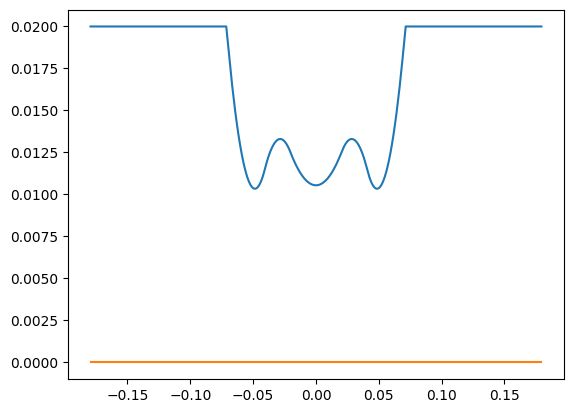

In [232]:
bar_, sections = mkCutSpline(es_state.best_member)
sections.plot(to_scale = False)

swp = xs.sweep(wood, bar_, sections, t.sweep_default)
swp.harmonics, swp.harmonics / fundamental, bar_.length



In [233]:
import optimistix
# solver = optimistix.GradientDescent(learning_rate = 0.001, rtol = 0.0000001, atol = 0.0000001)
solver = optimistix.BFGS(rtol = 1e-10, atol = 1e-10)
# solver = optimistix.NonlinearCG(rtol = 0.000001, atol = 0.000001)

solver = optimistix.BestSoFarMinimiser(solver)

# y0 = es_state.best_member

# fundamental = 440

# args = (wood, bar, fundamental, jnp.array([[0.5, 0.5], [1, -1.0], [2, 0.5], [3, -0.9], [4, 0.5], [5, -0.8]]))

sol = optimistix.minimise(lambda x,args: loss_spline(x), solver = solver, y0 = es_state.best_member, max_steps = None)



(Array([ 443.99999998, 1539.72266412, 3546.76903554], dtype=float64),
 Array([1.        , 3.46784384, 7.98821855], dtype=float64),
 0.36)

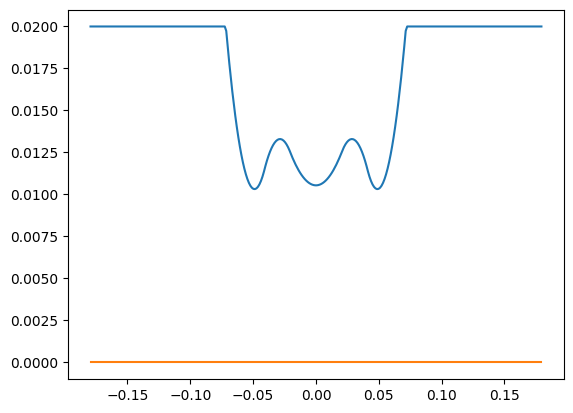

In [234]:
bar_, sections = mkCutSpline(sol.value)
sections.plot(to_scale = False)

swp = xs.sweep(wood, bar_, sections, t.sweep_default)
swp.harmonics, swp.harmonics / fundamental, bar_.length

(Array([1153.23311998, 3083.04555279, 5799.73045889], dtype=float64),
 Array([1.45772569, 3.8970739 , 7.33105555], dtype=float64),
 0.3)

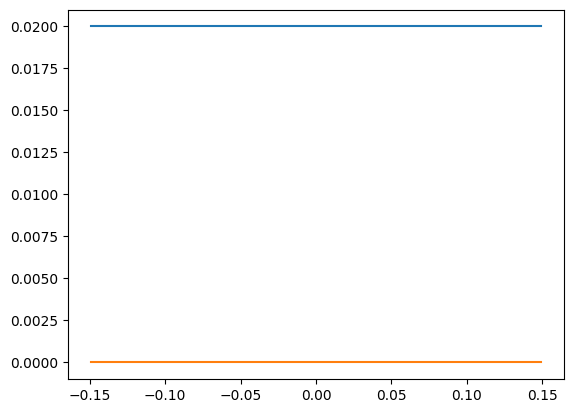

In [239]:
bar_, sections = mkCutSpline(jnp.array([1.0, 1.0, 1.0]))
sections.plot(to_scale = False)

swp = xs.sweep(wood, bar_, sections, t.sweep_default)
swp.harmonics, swp.harmonics / fundamental, bar_.length